# Lecture 21 - LINEAR DATA FITTING WITH UNCERTANTIES - HW 9

As scientists one of our many checks is to fit data to models.  Here, we will begin first by learning how to fit data with uncertanties to a linear fit (slope and intercept, and uncertanties) by using the python `scipy` module. 

In [1]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
#Read in the data to a numpy array
data = np.genfromtxt("LinearFit_data.txt", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

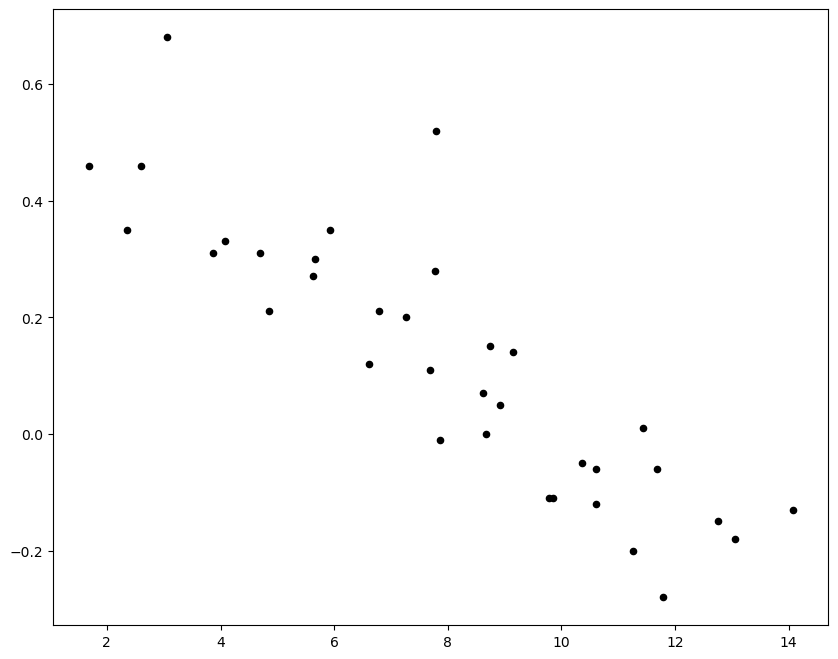

In [3]:
#First let's see what this data looks like
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [4]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.061902193399352975 0.6174204495463552
raw:  [ 3.63943119e-05 -2.88586096e-04] [-0.00028859  0.0026655 ]


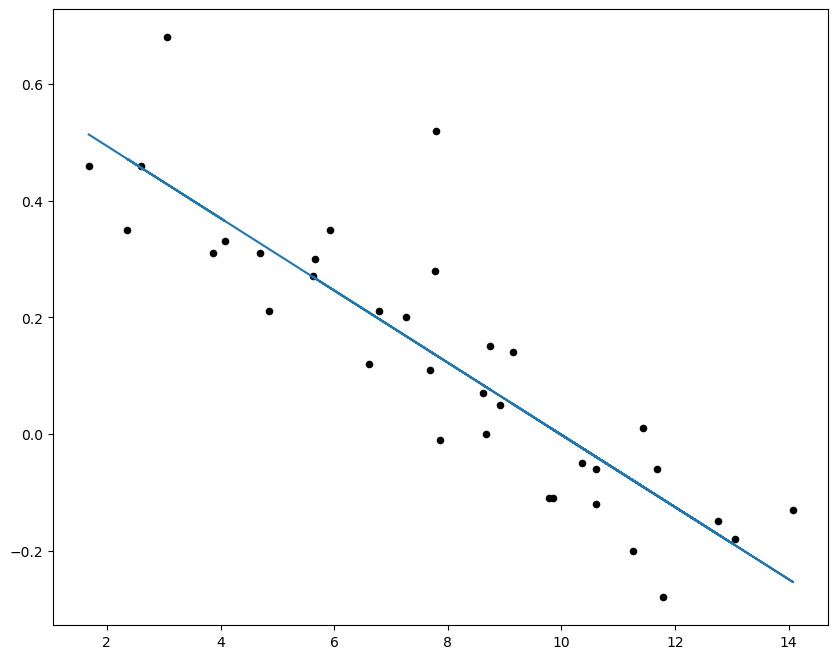

In [5]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


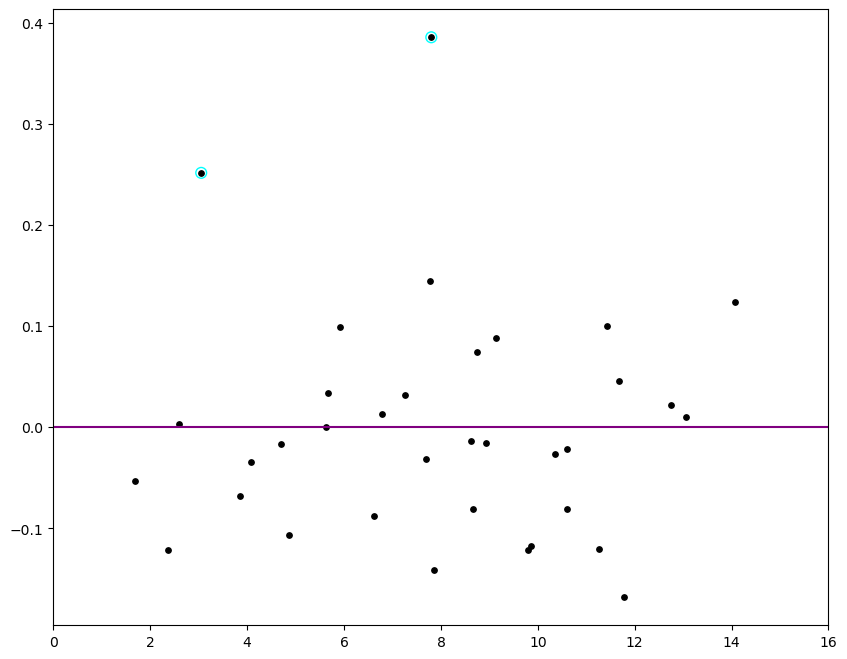

In [6]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(0,20,1000)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(0,16)

outlier = np.absolute(residual)>0.20
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.061902193399352975 0.6174204495463552
outliers accounted for:  -0.05813182372150089 0.5703220759875326


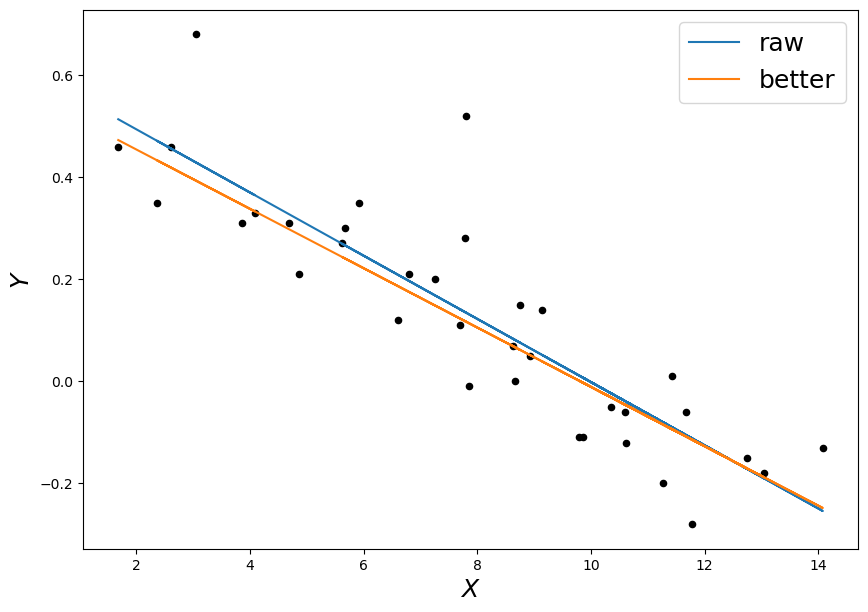

In [7]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.056065582969938695 0.5500877320339043


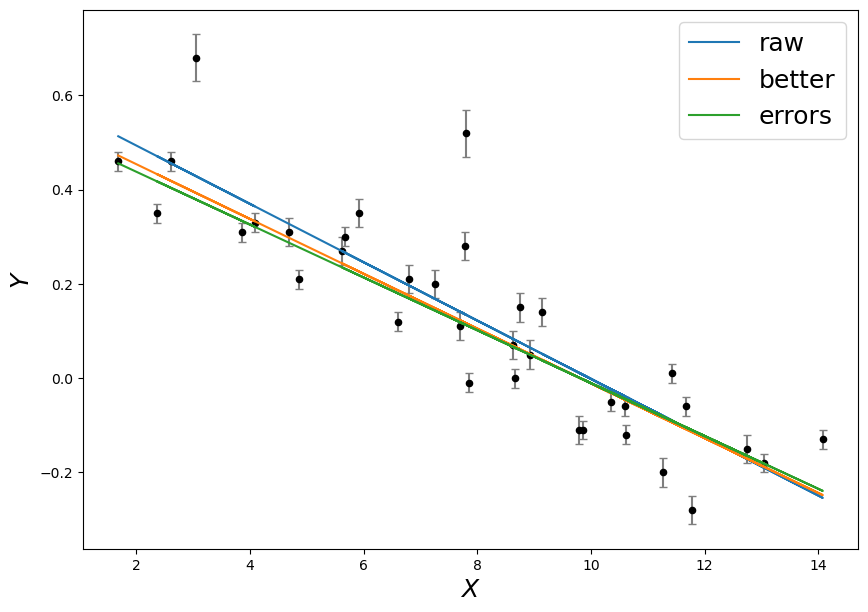

In [8]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0619, mean intercept: 0.6176


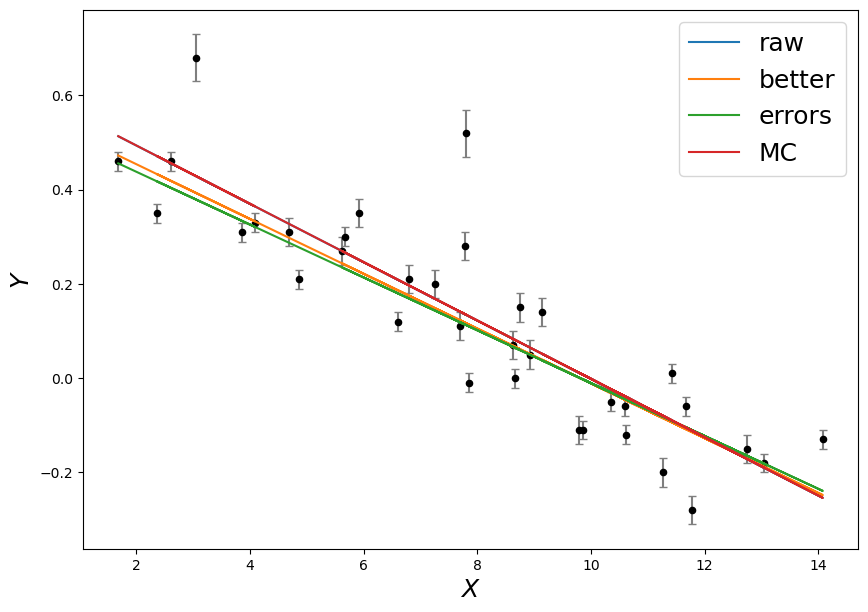

In [9]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

(array([ 2.,  2.,  0.,  4.,  6., 17., 24., 34., 59., 48., 63., 55., 54.,
        48., 34., 18., 17.,  5.,  7.,  3.]),
 array([-0.06662632, -0.06619337, -0.06576042, -0.06532747, -0.06489451,
        -0.06446156, -0.06402861, -0.06359566, -0.06316271, -0.06272975,
        -0.0622968 , -0.06186385, -0.0614309 , -0.06099795, -0.060565  ,
        -0.06013204, -0.05969909, -0.05926614, -0.05883319, -0.05840024,
        -0.05796728]),
 <BarContainer object of 20 artists>)

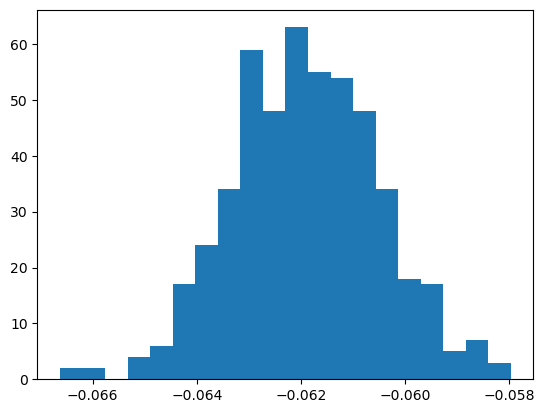

In [11]:
plt.hist(slope, bins=20)

In [12]:
# oh right, those outliers.

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  33
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5649


slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5646
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5652
slope: -0.0578 $\pm$ 0.0013, mean intercept: 0.5652
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5647
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5649
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5654
slope: -0.0577 $\pm$ 0.0012, mean intercept: 0.5645
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5649
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5655
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5656
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.5660
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5649
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5655
slope: -0.0578 $\pm$ 0.0012, mean intercept: 0.5651
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5657
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.5654
slope: -0.0579 $\pm$ 0.0012, mean intercept: 0.5656
slope: -0.0579 $\pm$ 0.0013, mean intercept: 0.

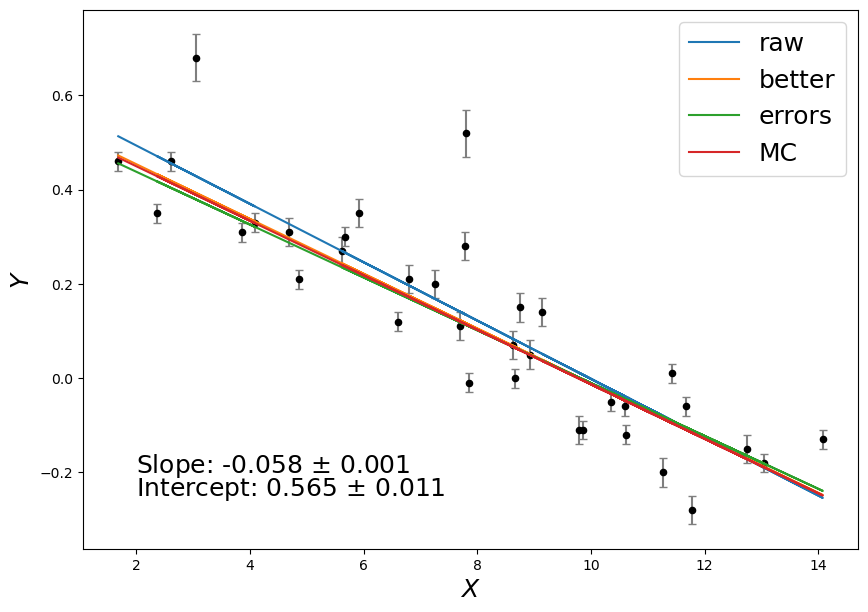

In [13]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

## Homework #10

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_23_HW10.ipynb

### Problem 1:
We can't know the x data perfectly suppose the data have uniform x errors of 0.5 use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors.



mean slope: -0.0080, mean intercept: 0.5230
data size:  48
slope: -0.0036 $\pm$ 0.0373, mean intercept: 0.2750


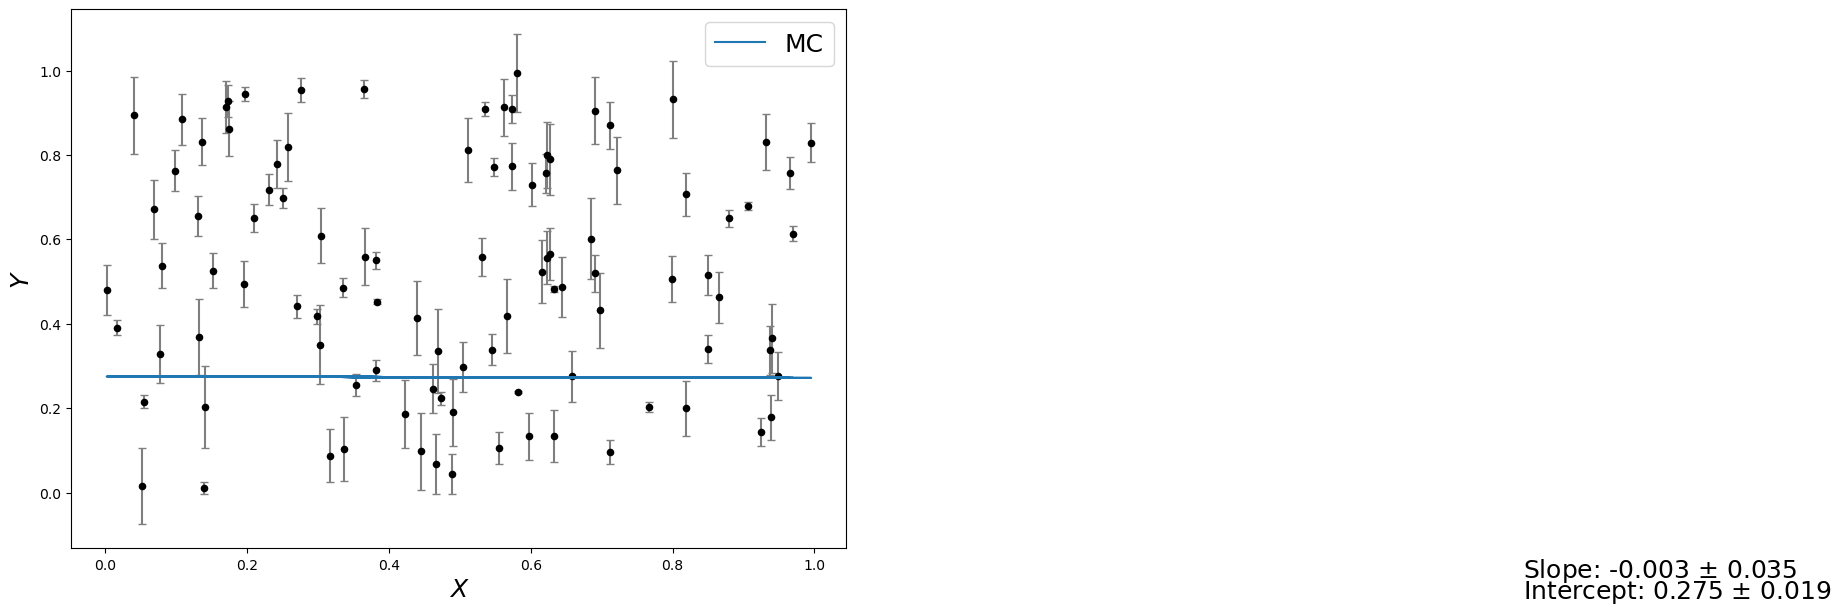

In [19]:
# code here

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
 
X_ERR = 0.5
 
def linear(x, slope, intercept):
    return slope * x + intercept
 
def mcFit(x, y, y_err, x_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y)) * y_err
        weights_x = np.random.randn(len(x)) * x_err
 
        y_adj = y + weights_y 
        x_adj = x + weights_x
 
        params, _ = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
 
    return slopes, y_ints
 
# Assuming data is a dictionary containing 'X', 'Y', 'Y_ERR'
data = {
    'X': np.random.rand(100),  # Placeholder for actual data
    'Y': np.random.rand(100),  # Placeholder for actual data
    'Y_ERR': np.random.rand(100) * 0.1  # Placeholder for actual data
}
 
slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'], X_ERR)
 
print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
 
mask = data['Y'] < 0.5 
 
xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]
 
print("data size: ", len(xdat))
 
slope, intercept = mcFit(xdat, ydat, ydat_err, X_ERR)
 
print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                      np.mean(intercept)))
 
# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'], s=20, c='black', zorder=2)
ax.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3, zorder=0)
 
slope, intercept = mcFit(xdat, ydat, ydat_err, X_ERR)
 
# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')
 
ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)
 
ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)
 
plt.legend(loc='best', fontsize=18)
plt.show()


### Problem 2:
Repeat problem #1 , but change the errors INCREASE as we move away from X = 8 (as they do) to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit.

Plot both slopes (Problem 1 & 2). How does the fit change? 

mean slope: 0.0063, mean intercept: 0.4570
data size:  48
new slope: -0.0038 $\pm$ 0.0028, mean intercept: 0.2402


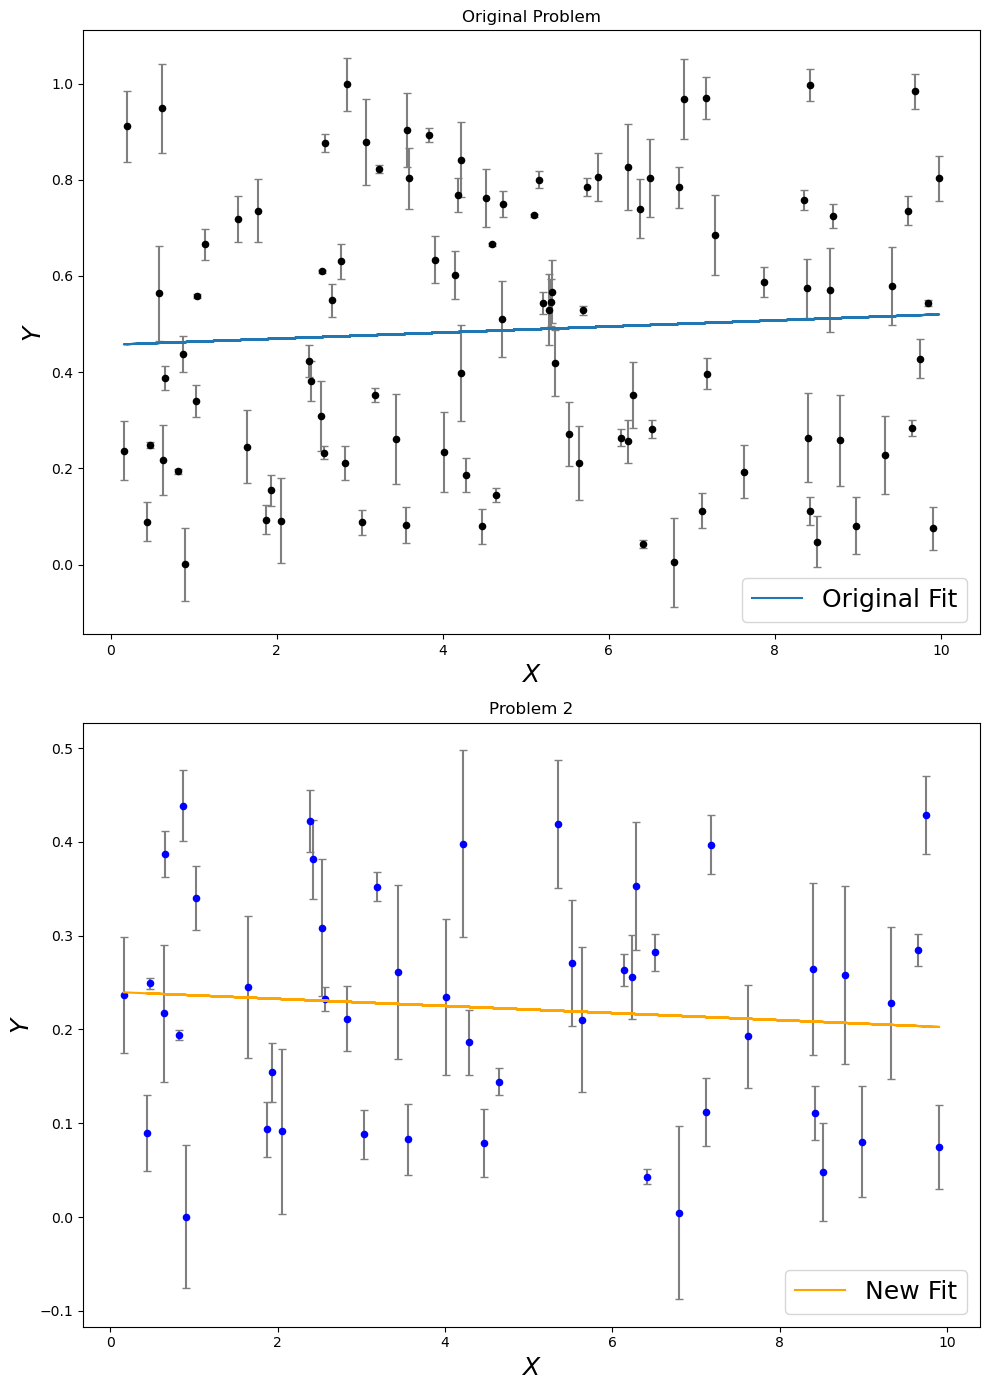

In [2]:
# code here

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
 
# Function to calculate dynamic error based on distance from X = 8
def calculate_x_err(x):
    return np.abs(x - 8) / 10
 
def linear(x, slope, intercept):
    return slope * x + intercept
 
def mcFit(x, y, y_err, x_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y)) * y_err
        weights_x = np.random.randn(len(x)) * x_err
 
        y_adj = y + weights_y 
        x_adj = x + weights_x
 
        params, _ = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
 
    return slopes, y_ints
 
# Assuming data is a dictionary containing 'X', 'Y', 'Y_ERR'
data = {
    'X': np.random.rand(100) * 10,  # Placeholder for actual data
    'Y': np.random.rand(100),  # Placeholder for actual data
    'Y_ERR': np.random.rand(100) * 0.1  # Placeholder for actual data
}
 
# Original X_ERR (constant)
X_ERR = 0.5
slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'], X_ERR)
 
print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
 
# Mask for data
mask = data['Y'] < 0.5 
 
xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]
 
print("data size: ", len(xdat))
 
# Calculate new X_ERR based on distance from 8
new_x_err = calculate_x_err(xdat)
slope_new, intercept_new = mcFit(xdat, ydat, ydat_err, new_x_err)
 
print('new slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope_new), np.std(slope_new),
                                                                       np.mean(intercept_new)))
 
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 14))
 
# Original problem plot
ax1 = axs[0]
ax1.scatter(data['X'], data['Y'], s=20, c='black', zorder=2)
ax1.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'], c='tab:gray', 
             fmt='.', markersize=1, capsize=3, zorder=0)
ax1.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='Original Fit')
ax1.set_title('Original Problem')
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)
ax1.legend(loc='best', fontsize=18)
 
# New problem plot
ax2 = axs[1]
ax2.scatter(xdat, ydat, s=20, c='blue', zorder=2)
ax2.errorbar(xdat, ydat, yerr=ydat_err, c='tab:gray', 
             fmt='.', markersize=1, capsize=3, zorder=0)
ax2.plot(xdat, linear(xdat, np.mean(slope_new), np.mean(intercept_new)), label='New Fit', color='orange')
ax2.set_title('Problem 2')
ax2.set_xlabel('$X$', fontsize=18)
ax2.set_ylabel('$Y$', fontsize=18)
ax2.legend(loc='best', fontsize=18)
 
plt.tight_layout()
plt.show()


### Problem 3: 
Repeat problem 1 & 2, but now anaylze for X vs. Z data, including both uniform 0.5 and X_ERR = |x - 8| /10 uncertainties.

mean slope: 0.0042, mean intercept: 0.5078
data size:  50
slope: -0.0012 $\pm$ 0.0372, mean intercept: 0.2475


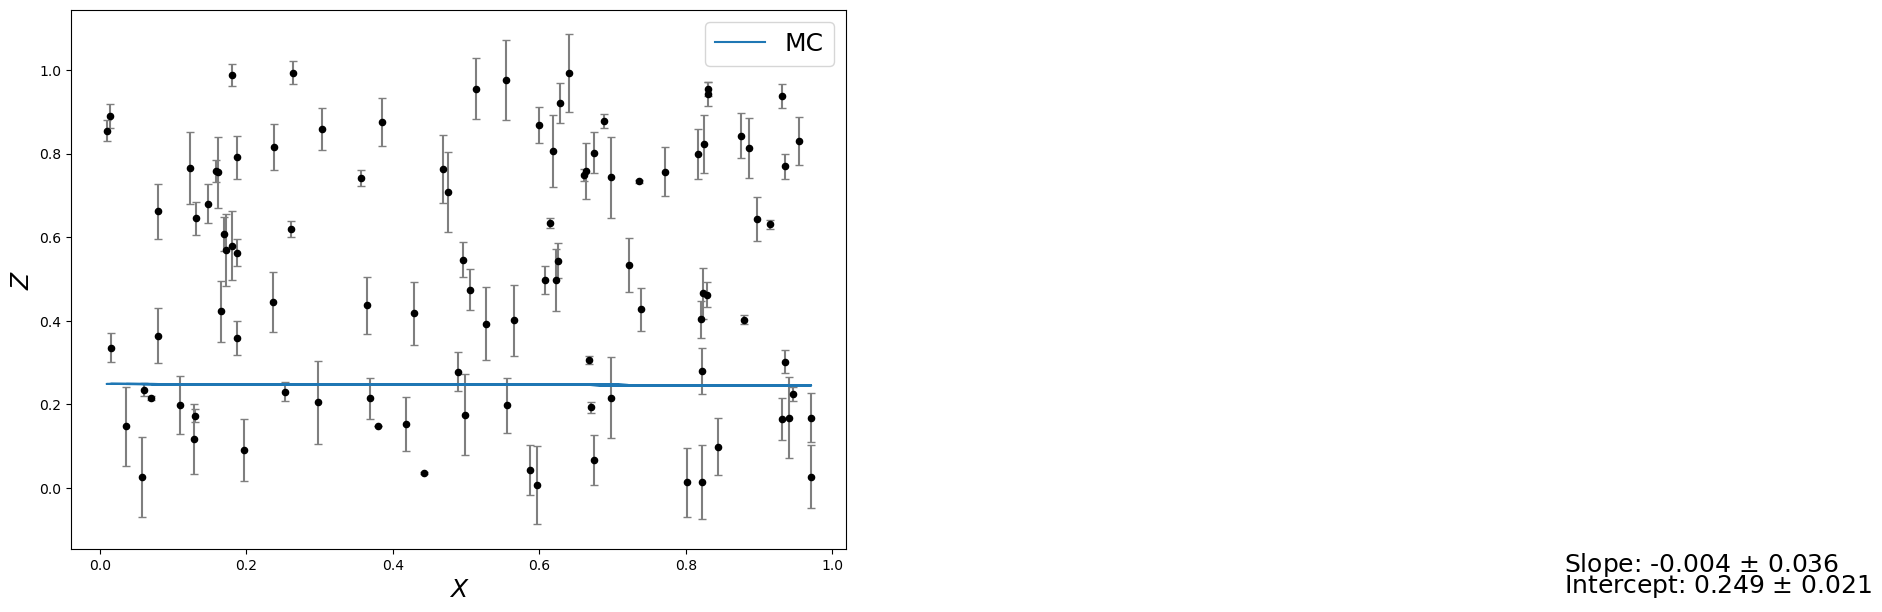

In [4]:
# code here

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
 
X_ERR = 0.5
 
def linear(x, slope, intercept):
    return slope * x + intercept
 
def mcFit(x, z, z_err, x_err):
    slopes = list()
    z_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_z = np.random.randn(len(z)) * z_err
        weights_x = np.random.randn(len(x)) * x_err
 
        z_adj = z + weights_z 
        x_adj = x + weights_x
 
        params, _ = opt.curve_fit(linear, x_adj, z_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
 
    return slopes, z_ints
 
# Assuming data is a dictionary containing 'X', 'Z', 'Z_ERR'
data = {
    'X': np.random.rand(100),  # Placeholder for actual data
    'Z': np.random.rand(100),  # Placeholder for actual data
    'Z_ERR': np.random.rand(100) * 0.1  # Placeholder for actual data
}
 
slope, intercept = mcFit(data['X'], data['Z'], data['Z_ERR'], X_ERR)
 
print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
 
mask = data['Z'] < 0.5 
 
xdat = data['X'][mask]
zdat = data['Z'][mask]
zdat_err = data['Z_ERR'][mask]
 
print("data size: ", len(xdat))
 
slope, intercept = mcFit(xdat, zdat, zdat_err, X_ERR)
 
print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                      np.mean(intercept)))
 
# Plotting
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'], s=20, c='black', zorder=2)
ax.errorbar(data['X'], data['Z'], yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3, zorder=0)
 
slope, intercept = mcFit(xdat, zdat, zdat_err, X_ERR)
 
# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')
 
ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)
 
ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)
 
plt.legend(loc='best', fontsize=18)
plt.show()
